In [1]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.utils import plot_model, to_categorical


## Data Loading and Processing

In [2]:
import os

DATA_DIR = ''
if 'google.colab' not in str(get_ipython()) and "anuja" in os.environ.get('USER'):
    DATA_DIR = 'data/'


In [3]:
# data loading
data = scipy.io.loadmat(DATA_DIR+'x_nofoof.mat')  
print(data['x'].shape)

columns = np.asarray([['Electrode %d - %d/2 Hz'%(i+1, j+1)] for i in range(data['x'].shape[1]) for j in range(data['x'].shape[2])])
labels = pd.read_csv("table_withlabels.csv")
foof = pd.read_csv("foof2features.csv")
beh = pd.read_csv("behaviorals.csv")
df = pd.DataFrame(data['x'].reshape((data['x'].shape[0], -1)))
df.columns = columns
df['IDs'] = foof['C1']
df = pd.merge(df, labels[['label', 'IDs']], on='IDs', how='inner')
print(df['label'].value_counts())

(2056, 105, 79)
Other Neurodevelopmental Disorders    492
ADHD-Inattentive Type                 388
ADHD-Combined Type                    376
Anxiety Disorders                     241
No Diagnosis Given                    203
Depressive Disorders                   85
Name: label, dtype: int64


In [4]:
# add labels
pd.options.mode.chained_assignment = None

df.label[df.label == 'Other Neurodevelopmental Disorders'] = 1
df.label[df.label == 'ADHD-Inattentive Type'] = 2
df.label[df.label == 'ADHD-Combined Type'] = 3
df.label[df.label == 'Anxiety Disorders'] = 4
df.label[df.label == 'No Diagnosis Given'] = 5
df.label[df.label == 'Depressive Disorders'] = 6
df.label = df['label'].astype(int)
labels = ['Other Neurodevelopmental Disorders', 'ADHD-Inattentive Type', 'ADHD-Combined Type', 'Anxiety Disorders', 'No Diagnosis Given', 'Depressive Disorders']

In [5]:
#WE HAD NANS!!!
df = pd.DataFrame(df)
df.shape
df.isnull().values.any()
df.isnull().sum()
df = df.dropna(axis='rows')
df


,"(Electrode 1 - 1/2 Hz,)","(Electrode 1 - 2/2 Hz,)","(Electrode 1 - 3/2 Hz,)","(Electrode 1 - 4/2 Hz,)","(Electrode 1 - 5/2 Hz,)","(Electrode 1 - 6/2 Hz,)","(Electrode 1 - 7/2 Hz,)","(Electrode 1 - 8/2 Hz,)","(Electrode 1 - 9/2 Hz,)","(Electrode 1 - 10/2 Hz,)","(Electrode 1 - 11/2 Hz,)","(Electrode 1 - 12/2 Hz,)","(Electrode 1 - 13/2 Hz,)","(Electrode 1 - 14/2 Hz,)","(Electrode 1 - 15/2 Hz,)","(Electrode 1 - 16/2 Hz,)","(Electrode 1 - 17/2 Hz,)","(Electrode 1 - 18/2 Hz,)","(Electrode 1 - 19/2 Hz,)","(Electrode 1 - 20/2 Hz,)","(Electrode 1 - 21/2 Hz,)","(Electrode 1 - 22/2 Hz,)","(Electrode 1 - 23/2 Hz,)","(Electrode 1 - 24/2 Hz,)","(Electrode 1 - 25/2 Hz,)","(Electrode 1 - 26/2 Hz,)","(Electrode 1 - 27/2 Hz,)","(Electrode 1 - 28/2 Hz,)","(Electrode 1 - 29/2 Hz,)","(Electrode 1 - 30/2 Hz,)","(Electrode 1 - 31/2 Hz,)","(Electrode 1 - 32/2 Hz,)","(Electrode 1 - 33/2 Hz,)","(Electrode 1 - 34/2 Hz,)","(Electrode 1 - 35/2 Hz,)","(Electrode 1 - 36/2 Hz,)","(Electrode 1 - 37/2 Hz,)","(Electrode 1 - 38/2 Hz,)","(Electrode 1 - 39/2 Hz,)","(Electrode 1 - 40/2 Hz,)",...,"(Electrode 105 - 42/2 Hz,)","(Electrode 105 - 43/2 Hz,)","(Electrode 105 - 44/2 Hz,)","(Electrode 105 - 45/2 Hz,)","(Electrode 105 - 46/2 Hz,)","(Electrode 105 - 47/2 Hz,)","(Electrode 105 - 48/2 Hz,)","(Electrode 105 - 49/2 Hz,)","(Electrode 105 - 50/2 Hz,)","(Electrode 105 - 51/2 Hz,)","(Electrode 105 - 52/2 Hz,)","(Electrode 105 - 53/2 Hz,)","(Electrode 105 - 54/2 Hz,)","(Electrode 105 - 55/2 Hz,)","(Electrode 105 - 56/2 Hz,)","(Electrode 105 - 57/2 Hz,)","(Electrode 105 - 58/2 Hz,)","(Electrode 105 - 59/2 Hz,)","(Electrode 105 - 60/2 Hz,)","(Electrode 105 - 61/2 Hz,)","(Electrode 105 - 62/2 Hz,)","(Electrode 105 - 63/2 Hz,)","(Electrode 105 - 64/2 Hz,)","(Electrode 105 - 65/2 Hz,)","(Electrode 105 - 66/2 Hz,)","(Electrode 105 - 67/2 Hz,)","(Electrode 105 - 68/2 Hz,)","(Electrode 105 - 69/2 Hz,)","(Electrode 105 - 70/2 Hz,)","(Electrode 105 - 71/2 Hz,)","(Electrode 105 - 72/2 Hz,)","(Electrode 105 - 73/2 Hz,)","(Electrode 105 - 74/2 Hz,)","(Electrode 105 - 75/2 Hz,)","(Electrode 105 - 76/2 Hz,)","(Electrode 105 - 77/2 Hz,)","(Electrode 105 - 78/2 Hz,)","(Electrode 105 - 79/2 Hz,)",IDs,label
0,22.646692,21.409617,11.791191,7.654361,5.294041,4.281935,3.556075,2.891063,2.375165,2.321368,2.144142,2.316871,2.413091,2.602494,3.127900,6.126276,7.840128,7.945180,5.426339,2.599921,1.171686,0.834308,0.711654,0.581244,0.485108,0.411796,0.399999,0.357496,0.369367,0.334815,0.294607,0.285368,0.272610,0.295438,0.283785,0.299308,0.279714,0.244252,0.228658,0.204711,...,0.036439,0.036266,0.035957,0.036827,0.034125,0.031669,0.029758,0.028280,0.027731,0.028988,0.029513,0.026551,0.023687,0.021718,0.022060,0.022272,0.021688,0.020814,0.018080,0.016527,0.015884,0.014964,0.013776,0.013935,0.013940,0.013750,0.012560,0.013276,0.013812,0.014442,0.013248,0.011966,0.011954,0.011685,0.012114,0.011274,0.011133,0.009402,NDARAA075AMK,5
1,35.803485,31.315928,20.393061,13.173540,6.198943,4.636760,4.205091,4.182367,3.032023,2.775398,2.444941,2.215734,1.788818,1.638520,1.535773,1.319914,1.077808,0.813806,0.685941,0.547122,0.527190,0.506139,0.434129,0.361699,0.340934,0.308341,0.346585,0.307801,0.279930,0.252056,0.301698,0.325598,0.357748,0.354070,0.306328,0.255585,0.231481,0.228635,0.211165,0.210914,...,0.185115,0.150531,0.140546,0.135327,0.136179,0.127057,0.124557,0.124492,0.099661,0.083384,0.085427,0.099015,0.095276,0.075890,0.076641,0.060247,0.064177,0.060440,0.058296,0.052401,0.045368,0.050280,0.046702,0.048642,0.038527,0.040631,0.033066,0.036158,0.029886,0.029482,0.035029,0.032905,0.029361,0.025549,0.021678,0.023353,0.021711,0.023934,NDARAA112DMH,3
2,13.719575,13.953344,8.733713,5.339339,3.654114,3.280150,3.597552,3.324361,2.615713,1.973499,1.444864,1.448659,1.467536,1.424597,1.544466,1.845957,3.245325,4.243817,4.170516,3.156451,1.481642,0.683608,0.461722,0.329293,0.255754,0.230899,0.214032,0.195232,0.174679,0.174852,0.156000,0.148260,0.143997,0.173226,0.173884,0.169246,0.135366,0.130309,0.134199,0.14

In [6]:
# data splitting

train_df, test_df = train_test_split(df, test_size=0.3, stratify=df['label'])

train_labels, test_labels = train_df['label'], test_df['label']
test_labels_categorical = to_categorical(test_df['label']-1)

train_features = train_df[train_df.columns.difference(['IDs', 'label'])]
test_features = test_df[test_df.columns.difference(['IDs', 'label'])]

## AutoEncoder for Feature Extraction

In [7]:
n_inputs = train_features.shape[1]

visible = Input(shape=(n_inputs,))
e = Dense(n_inputs*2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
e = Dense(n_inputs)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
n_bottleneck = round(float(n_inputs) / 2.0)
bottleneck = Dense(n_bottleneck)(e)

d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

d = Dense(n_inputs*2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

output = Dense(n_inputs, activation='linear')(d)

model = Model(inputs=visible, outputs=output)
model.compile(optimizer='adam', loss='mse')
plot_model(model, 'autoencoder_compress.png', show_shapes=True)

history = model.fit(train_features, train_labels, epochs=15, batch_size=16, verbose=2)
encoder = Model(inputs=visible, outputs=bottleneck)

plot_model(encoder, 'encoder_compress.png', show_shapes=True)
encoder.save('autoencoder.h5')

Epoch 1/15
78/78 - 8s - loss: 6.1387 - 8s/epoch - 102ms/step
Epoch 2/15
78/78 - 5s - loss: 4.4664 - 5s/epoch - 62ms/step
Epoch 3/15
78/78 - 5s - loss: 3.5229 - 5s/epoch - 62ms/step
Epoch 4/15
78/78 - 5s - loss: 3.8873 - 5s/epoch - 62ms/step
Epoch 5/15
78/78 - 5s - loss: 3.2212 - 5s/epoch - 62ms/step
Epoch 6/15
78/78 - 5s - loss: 3.4156 - 5s/epoch - 62ms/step
Epoch 7/15
78/78 - 5s - loss: 3.2098 - 5s/epoch - 62ms/step
Epoch 8/15
78/78 - 5s - loss: 2.7315 - 5s/epoch - 62ms/step
Epoch 9/15
78/78 - 5s - loss: 2.8569 - 5s/epoch - 62ms/step
Epoch 10/15
78/78 - 5s - loss: 3.2480 - 5s/epoch - 62ms/step
Epoch 11/15
78/78 - 5s - loss: 3.2893 - 5s/epoch - 62ms/step
Epoch 12/15
78/78 - 5s - loss: 3.1940 - 5s/epoch - 62ms/step
Epoch 13/15
78/78 - 5s - loss: 3.1729 - 5s/epoch - 62ms/step
Epoch 14/15
78/78 - 5s - loss: 3.0703 - 5s/epoch - 62ms/step
Epoch 15/15
78/78 - 5s - loss: 3.0821 - 5s/epoch - 62ms/step


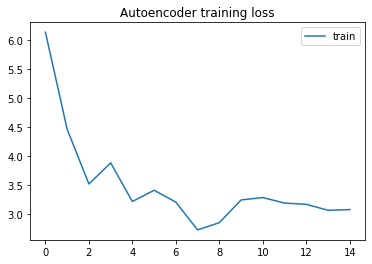

In [8]:
  # plot loss
  plt.plot(history.history['loss'], label='train')
  plt.title('Autoencoder training loss')
  plt.legend()
  plt.show()

In [9]:
# encode the data
encoder= load_model('autoencoder.h5', compile=False)

train_features_encoded = encoder.predict(train_features)
test_features_encoded = encoder.predict(test_features)

## Dealing with imbalance

In [10]:
oversample = SMOTE()
train_features_encoded_oversampled, train_labels_oversampled = oversample.fit_resample(train_features_encoded, train_labels)
train_features_oversampled, train_labels_oversampled_ = oversample.fit_resample(train_features, train_labels)

train_labels_oversampled_categorical = to_categorical(train_labels_oversampled-1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['tuple']. An error will be raised in 1.2.
  FutureWarning,


In [11]:
if 'google.colab' in str(get_ipython()):
  np.save('train_features_encoded_oversampled.npy', train_features_encoded_oversampled)
  np.save('train_labels_oversampled.npy', train_labels_oversampled)
  np.save('train_features_encoded.npy', train_features_encoded)
  np.save('test_features_encoded.npy', test_features_encoded)

In [12]:
# scaling the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
train_features_encoded_oversampled = scaler.fit_transform(train_features_encoded_oversampled)
test_features_encoded = scaler.transform(test_features_encoded)

train_features_encoded_oversampled = np.clip(train_features_encoded_oversampled, -5, 5)
test_features_encoded = np.clip(test_features_encoded, -5, 5)

In [13]:
print(train_features_encoded_oversampled.shape)
print(train_labels_oversampled.shape)
print(train_labels_oversampled_categorical.shape)
print(test_features_encoded.shape)
print(test_labels.shape)

(2046, 4148)
(2046,)
(2046, 6)
(532, 4148)
(532,)


## Linear Models

### SVC

In [14]:
from sklearn import svm

clf = svm.SVC(kernel='linear', verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)

predicted_labels_svc = clf.predict(test_features_encoded)

[LibSVM]

In [15]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate(y_test, y_pred, show_cm=True, is_categorical=False):
    
    if is_categorical:
      y_test = np.argmax(y_test, axis=1)
      y_pred = np.argmax(y_pred, axis=1)

    print("Accuracy:", metrics.accuracy_score(y_test, y_pred))
    print("Precision:", metrics.precision_score(y_test, y_pred, average='macro'))
    print("Recall:", metrics.recall_score(y_test, y_pred, average='macro'))
#     print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred, multi_class='ovo',))
    print("F1 score:", metrics.f1_score(y_test, y_pred, average='macro'))
#     print("Brier Score:", metrics.brier_score_loss(y_test, y_pred)) # only for binary classification

    if show_cm:
        cm = confusion_matrix(y_test, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
        disp.plot()
        plt.tight_layout()
        plt.show()


Accuracy: 0.18796992481203006
Precision: 0.17065436632813855
Recall: 0.18362280684552768
F1 score: 0.1699975714653396


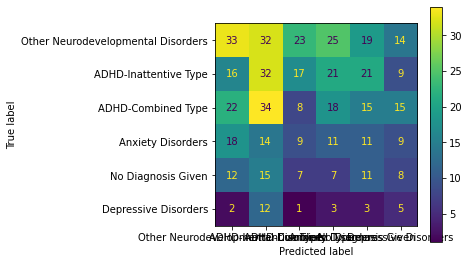

In [16]:
evaluate(test_labels, predicted_labels_svc)

### OneVsRestClassifier
The strategy consists in fitting one classifier per class. For each classifier, the class is fitted against all the other classes.

In [17]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC

clf = OneVsRestClassifier(LinearSVC(random_state=0, max_iter=2000, verbose=True))

clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_ovr = clf.predict(test_features_encoded)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.17293233082706766
Precision: 0.16641047163436654
Recall: 0.1628173514539835
F1 score: 0.14336884803122052


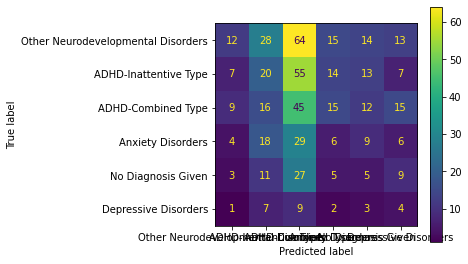

In [18]:
evaluate(test_labels, predicted_labels_ovr)

### OneVsOneClassifier
OneVsOneClassifier constructs one classifier per pair of classes. At prediction time, the class which received the most votes is selected. In the event of a tie (among two classes with an equal number of votes), it selects the class with the highest aggregate classification confidence by summing over the pair-wise classification confidence levels computed by the underlying binary classifiers.



In [19]:
from sklearn.multiclass import OneVsOneClassifier

clf = OneVsOneClassifier(LinearSVC(random_state=0, verbose=True))

clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_ovo = clf.predict(test_features_encoded)

[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


[LibLinear]

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Accuracy: 0.17293233082706766
Precision: 0.16641047163436654
Recall: 0.1628173514539835
F1 score: 0.14336884803122052


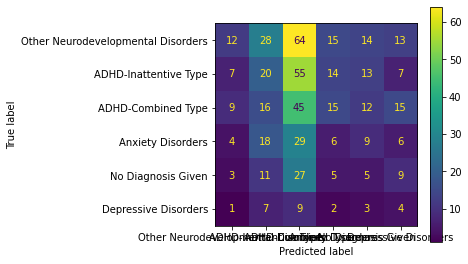

In [20]:
evaluate(test_labels, predicted_labels_ovr)

### Random Forest

In [21]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(max_depth=5, random_state=0, verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_rf = clf.predict(test_features_encoded)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    4.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.0s finished


Accuracy: 0.19172932330827067
Precision: 0.191242746873057
Recall: 0.18284959378783186
F1 score: 0.17732852175934136


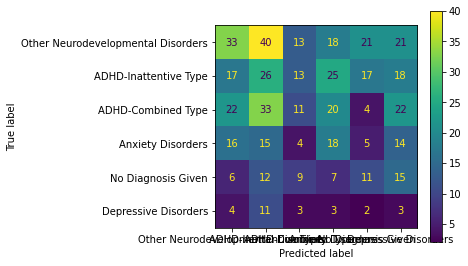

In [22]:
evaluate(test_labels, predicted_labels_rf)

### MLP


In [23]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(random_state=1, max_iter=300, verbose=True)
clf.fit(train_features_encoded_oversampled, train_labels_oversampled)
predicted_labels_mlp = clf.predict(test_features_encoded)

Iteration 1, loss = 3.86100624
Iteration 2, loss = 2.64930913
Iteration 3, loss = 2.18732291
Iteration 4, loss = 1.99186157
Iteration 5, loss = 1.96917694
Iteration 6, loss = 2.15829716
Iteration 7, loss = 2.08175244
Iteration 8, loss = 2.13086236
Iteration 9, loss = 1.98140743
Iteration 10, loss = 2.01677760
Iteration 11, loss = 2.19421807
Iteration 12, loss = 2.03547232
Iteration 13, loss = 1.97228440
Iteration 14, loss = 1.98160026
Iteration 15, loss = 1.98776545
Iteration 16, loss = 1.91770325
Iteration 17, loss = 1.94235630
Iteration 18, loss = 1.85732123
Iteration 19, loss = 1.87772778
Iteration 20, loss = 1.95724174
Iteration 21, loss = 2.25136162
Iteration 22, loss = 2.11752480
Iteration 23, loss = 2.13606913
Iteration 24, loss = 2.08429930
Iteration 25, loss = 2.03088719
Iteration 26, loss = 1.94318358
Iteration 27, loss = 1.94302126
Iteration 28, loss = 1.99440600
Iteration 29, loss = 1.99112016
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. S

Accuracy: 0.15413533834586465
Precision: 0.24244050219646704
Recall: 0.1776904322605787
F1 score: 0.1217235605388191


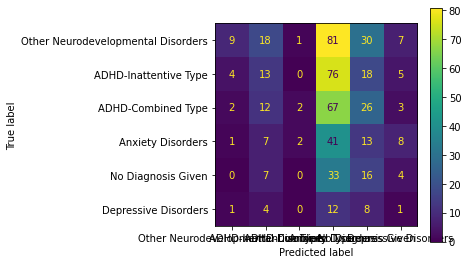

In [24]:
evaluate(test_labels, predicted_labels_mlp)

## CNNs

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D 
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
# print('Tensorflow Version: ',tensorflow.__version__)
from tensorflow.keras.layers import BatchNormalization

def get_CNN_classifier():
  # Initialising the CNN
  model = Sequential()
  # Convolution
  model.add(Conv1D(filters = 32, kernel_size = 3, input_shape = (79, 105), activation = 'relu', padding = 'same'))
  # Pooling
  model.add(MaxPooling1D(pool_size = 2))
  # Convolution
  model.add(Conv1D(filters = 64, kernel_size = 3, input_shape = (39, 32), activation = 'relu', padding = 'same'))
  model.add(Conv1D(filters = 64, kernel_size = 3, input_shape = (39, 64), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters =128, kernel_size = 3, input_shape = (19, 64), activation = 'relu', padding = 'same'))
  # model.add(Conv1D(filters =128, kernel_size = 3, input_shape = (19, 128), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters =256, kernel_size = 3, input_shape = (9, 128), activation = 'relu', padding = 'same'))
  #model.add(Conv1D(filters =256, kernel_size = 3, input_shape = (9, 256), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters =512, kernel_size = 3, input_shape = (4, 256), activation = 'relu', padding = 'same'))
  #model.add(Conv1D(filters =512, kernel_size = 3, input_shape = (4, 512), activation = 'relu', padding = 'same'))
  model.add(BatchNormalization())
  model.add(MaxPooling1D(pool_size = 2))
  model.add(Conv1D(filters = 1024, kernel_size = 3, input_shape = (2, 512), activation = 'relu', padding = 'same'))
  model.add(Conv1D(filters = 1024, kernel_size = 3, input_shape = (2, 1028), activation = 'relu', padding = 'same'))
  model.add(MaxPooling1D(pool_size = 2))
  # Flattening
  model.add(Flatten())

  model.add(Dense(units = 6, activation = 'softmax'))
  # Compiling the CNN
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  model.summary()
  
  return model

CNN_model = get_CNN_classifier()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 79, 32)            10112     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 39, 32)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 39, 64)            6208      
                                                                 
 conv1d_2 (Conv1D)           (None, 39, 64)            12352     
                                                                 
 batch_normalization_4 (Batc  (None, 39, 64)           256       
 hNormalization)                                                 
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 19, 64)           0

In [26]:
# data reshaping for CNN
n_electrode = 105
n_freq =79 

train_features_oversampled_reshaped = train_features_oversampled.to_numpy().reshape((train_features_oversampled.shape[0], n_electrode, n_freq))
test_features_reshaped = test_features.to_numpy().reshape((test_features.shape[0], n_electrode, n_freq))

In [27]:
history_CNN = CNN_model.fit(np.transpose(train_features_oversampled_reshaped, (0, 2, 1)), train_labels_oversampled_categorical, validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
52/52 [==============================] - 17s 25ms/step - loss: 2.1458 - accuracy: 0.2029 - val_loss: 3.3044 - val_accuracy: 0.0000e+00
Epoch 2/100
52/52 [==============================] - 1s 14ms/step - loss: 1.7112 - accuracy: 0.2372 - val_loss: 6.1246 - val_accuracy: 0.0000e+00
Epoch 3/100
52/52 [==============================] - 1s 15ms/step - loss: 1.7031 - accuracy: 0.2592 - val_loss: 5.0743 - val_accuracy: 0.0000e+00
Epoch 4/100
52/52 [==============================] - 1s 14ms/step - loss: 1.6822 - accuracy: 0.2726 - val_loss: 4.9790 - val_accuracy: 0.0000e+00
Epoch 5/100
52/52 [==============================] - 1s 15ms/step - loss: 1.6742 - accuracy: 0.2604 - val_loss: 2.8143 - val_accuracy: 0.0000e+00
Epoch 6/100
52/52 [==============================] - 1s 15ms/step - loss: 1.6744 - accuracy: 0.2793 - val_loss: 2.7229 - val_accuracy: 0.0049
Epoch 7/100
52/52 [==============================] - 1s 14ms/step - loss: 1.6549 - accuracy: 0.2800 - val_loss: 3.5320 - val_ac

Accuracy: 0.18984962406015038
Precision: 0.13934841613413043
Recall: 0.14787249164610997
F1 score: 0.14166637871328944


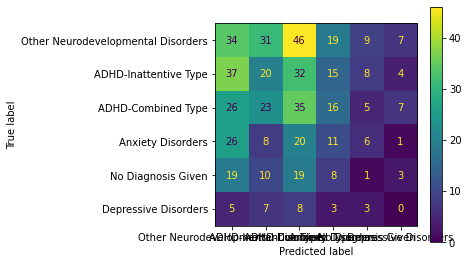

In [28]:
predicted_labels_cnn = CNN_model.predict(np.transpose(test_features_reshaped, (0, 2, 1)))
evaluate(test_labels_categorical, predicted_labels_cnn, is_categorical=True)

In [29]:
from tensorflow.keras.layers import Conv2D , MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
#dilation of the filters , for deeper  convolutionm try with the whole signal
def get_CNN_2_classifier():

    k = 3  # kernel size
    s = 2  # stride
    n_filters = 32 # number of filters
    inputs = Input(shape=(79, 105, 1))

    conv1 = Conv2D(n_filters, kernel_size=(k, k), strides=(s, s), padding='same')(inputs)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = LeakyReLU(alpha=0.2)(conv1)
    conv1 = Conv2D(n_filters, kernel_size=(k, k), padding='same')(conv1)
    conv1 = BatchNormalization(scale=False, axis=3)(conv1)
    conv1 = LeakyReLU(alpha=0.1)(conv1)
    pool1 = MaxPooling2D(pool_size=(s, s))(conv1)

    conv2 = Conv2D(2 * n_filters, kernel_size=(k, k), strides=(s, s), padding='same')(pool1)
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = LeakyReLU(alpha=0.3)(conv2)
    conv2 = Conv2D(2 * n_filters, kernel_size=(k, k), padding='same')(conv2)
    conv2 = BatchNormalization(scale=False, axis=3)(conv2)
    conv2 = LeakyReLU(alpha=0.1)(conv2)
    pool2 = MaxPooling2D(pool_size=(s, s))(conv2)

    conv3 = Conv2D(4 * n_filters, kernel_size=(k, k), padding='same')(pool2)
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    conv3 = Conv2D(4 * n_filters, kernel_size=(k, k), padding='same')(conv3)
    conv3 = BatchNormalization(scale=False, axis=3)(conv3)
    conv3 = LeakyReLU(alpha=0.1)(conv3)
    pool3 = MaxPooling2D(pool_size=(s, s))(conv3)

    conv4 = Conv2D(8 * n_filters, kernel_size=(k, k), padding='same')(pool3)
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    conv4 = Conv2D(8 * n_filters, kernel_size=(k, k), padding='same')(conv4)
    conv4 = BatchNormalization(scale=False, axis=3)(conv4)
    conv4 = LeakyReLU(alpha=0.1)(conv4)
    pool4 = MaxPooling2D(pool_size=(s, s))(conv4)

    conv5 = Conv2D(16 * n_filters, kernel_size=(k, k), padding='same')(pool4)
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)
    conv5 = Conv2D(16 * n_filters, kernel_size=(k, k), padding='same')(conv5)
    conv5 = BatchNormalization(scale=False, axis=3)(conv5)
    conv5 = LeakyReLU(alpha=0.1)(conv5)

    gap = GlobalAveragePooling2D()(conv5)
    outputs = Dense(6, activation='softmax')(gap)

    model = Model(inputs, outputs)
    model.compile(optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
    model.summary()
  
    return model

CNN_model_2 = get_CNN_2_classifier()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 79, 105, 1)]      0         
                                                                 
 conv2d (Conv2D)             (None, 40, 53, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 40, 53, 32)       96        
 hNormalization)                                                 
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 40, 53, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 53, 32)        9248      
                                                                 
 batch_normalization_9 (Batc  (None, 40, 53, 32)       96        
 hNormalization)                                           

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [30]:
history_CNN_2 = CNN_model_2.fit(np.transpose(train_features_oversampled_reshaped, (0, 2, 1)), train_labels_oversampled_categorical, validation_split=0.2, epochs=50, verbose=1)


Epoch 1/50
52/52 [==============================] - 3s 24ms/step - loss: 1.8812 - accuracy: 0.2445 - val_loss: 1.8641 - val_accuracy: 0.0000e+00
Epoch 2/50
52/52 [==============================] - 1s 14ms/step - loss: 1.5691 - accuracy: 0.3759 - val_loss: 1.9922 - val_accuracy: 0.0000e+00
Epoch 3/50
52/52 [==============================] - 1s 14ms/step - loss: 1.4094 - accuracy: 0.4505 - val_loss: 2.0837 - val_accuracy: 0.0000e+00
Epoch 4/50
52/52 [==============================] - 1s 14ms/step - loss: 1.2327 - accuracy: 0.5446 - val_loss: 2.2649 - val_accuracy: 0.0146
Epoch 5/50
52/52 [==============================] - 1s 13ms/step - loss: 1.1963 - accuracy: 0.5520 - val_loss: 2.2874 - val_accuracy: 0.0317
Epoch 6/50
52/52 [==============================] - 1s 13ms/step - loss: 0.9776 - accuracy: 0.6369 - val_loss: 2.1567 - val_accuracy: 0.0780
Epoch 7/50
52/52 [==============================] - 1s 13ms/step - loss: 0.8445 - accuracy: 0.6962 - val_loss: 1.9735 - val_accuracy: 0.1854
E

Accuracy: 0.20676691729323307
Precision: 0.13661254582307214
Recall: 0.14255518128628664
F1 score: 0.1270112261079452


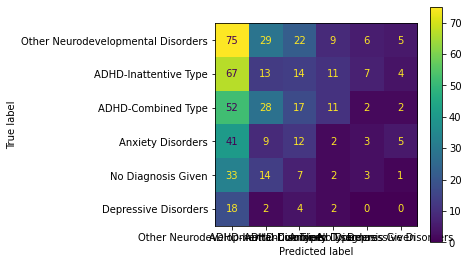

In [31]:
predicted_labels_cnn_2 = CNN_model_2.predict(np.transpose(test_features_reshaped, (0, 2, 1)))
evaluate(test_labels_categorical, predicted_labels_cnn_2, is_categorical=True)

In [32]:
def get_CNN_3_classifier():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(79, 105, 1)))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(6, activation='softmax'))

  model.compile(optimizer = Adam(lr=1e-4), loss = 'categorical_crossentropy', metrics = ['accuracy'])
  model.summary()

  return model

CNN_model_3 = get_CNN_3_classifier()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 77, 103, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 38, 51, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 38, 51, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 36, 49, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 18, 24, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 18, 24, 64)       

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [33]:
history_cnn_3 = CNN_model_3.fit(np.transpose(train_features_oversampled_reshaped, (0, 2, 1)), train_labels_oversampled_categorical, validation_split=0.2, epochs=100, verbose=1)

Epoch 1/100
52/52 [==============================] - 1s 13ms/step - loss: 1.9269 - accuracy: 0.2023 - val_loss: 2.4215 - val_accuracy: 0.0000e+00
Epoch 2/100
52/52 [==============================] - 0s 8ms/step - loss: 1.7507 - accuracy: 0.2249 - val_loss: 2.0988 - val_accuracy: 0.0049
Epoch 3/100
52/52 [==============================] - 0s 9ms/step - loss: 1.7198 - accuracy: 0.2292 - val_loss: 2.5285 - val_accuracy: 0.0000e+00
Epoch 4/100
52/52 [==============================] - 0s 8ms/step - loss: 1.6976 - accuracy: 0.2677 - val_loss: 2.3229 - val_accuracy: 0.0000e+00
Epoch 5/100
52/52 [==============================] - 0s 9ms/step - loss: 1.6841 - accuracy: 0.2622 - val_loss: 2.3441 - val_accuracy: 0.0634
Epoch 6/100
52/52 [==============================] - 0s 8ms/step - loss: 1.6604 - accuracy: 0.2958 - val_loss: 2.2728 - val_accuracy: 0.0098
Epoch 7/100
52/52 [==============================] - 0s 8ms/step - loss: 1.6495 - accuracy: 0.2830 - val_loss: 2.1372 - val_accuracy: 0.0756


Accuracy: 0.19924812030075187
Precision: 0.16327961804694544
Recall: 0.15727897974591407
F1 score: 0.15977046614333293


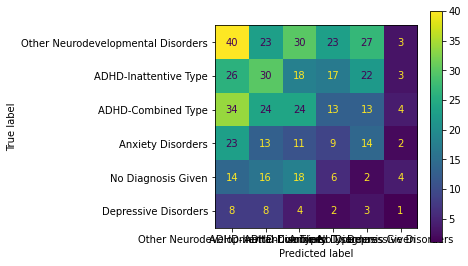

In [34]:
predicted_labels_cnn_3 = CNN_model_3.predict(np.transpose(test_features_reshaped, (0, 2, 1)))
evaluate(test_labels_categorical, predicted_labels_cnn_3, is_categorical=True)

## Ensemble Learning

In [35]:
# from self_paced_ensemble import SelfPacedEnsembleClassifier

# clf = SelfPacedEnsembleClassifier(base_estimator=RandomForestClassifier(max_depth=5, random_state=0, verbose=True), n_estimators=5)


# clf.fit(train_features, train_labels)
